<div align="left">
<img align="left" src="datasciencebowl.png" >
<div> <b> Kaggle </b></div>
<div> 2018 Data Science Bowl </div>
<div> Pedro D. Marrero Fernandez</div>
<div> https://www.kaggle.com/c/data-science-bowl-2018/discussion/47770 </div>
<div> :), :(, :/</div>
</div>

In [1]:
import os
import torch
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt


import scipy.misc
from skimage import color
from skimage import io, transform
import cv2

import torch
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable
import torch.nn.functional as nnfun

from deep.datasets import imageutl as imutl
from deep.datasets import utility as utl
from deep.datasets import weightmaps 
from deep import netmodels as nnmodels
from deep import visualization as view
from deep import netutility as nutl
from deep import neuralnet as deepnet
from deep import postprocessing as posp
from deep import processing as proc

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
def imageshowlist(image_in, image_out ):    
    plt.figure( figsize=(16,16))
    plt.subplot(121)
    plt.imshow( image_in )
    plt.title('Image input')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow( image_out )
    plt.title('Image output')
    plt.axis('off')
    plt.show()

def imageshow( image, title='image'):
    plt.figure( figsize=(8,8))
    plt.imshow( image )
    plt.axis('off')
    plt.show()

In [3]:
# configuration
PATHDATASET = '../db'
NAMEDATASET = 'databoewl'
METADATA = 'stage1_train_labels.csv'
PATHMODEL = 'netruns/experiment_unet_fx_c0001'
NAMEMODEL = 'chk000815.pth.tar'
RLNAME = 'test_masks.csv'
NUMITER = 5
PATHNAMEDATASET = os.path.join(PATHDATASET, NAMEDATASET);
PATHNAMEDMETADATA = os.path.join(PATHDATASET, NAMEDATASET, METADATA)
PATHNAMEMODEL = os.path.join(PATHMODEL, NAMEMODEL)

In [4]:
base_folder = PATHNAMEDATASET
sub_folder =  imutl.testfilefinal
folders_image='images'

dataloader = imutl.dsxbImageProvide.create(
    base_folder, 
    sub_folder, 
    folders_image, 
    )

print(len(dataloader))
print(':)!!!')


3019
:)!!!


In [6]:
segment = proc.Net( )
segment.loadmodel( PATHNAMEMODEL )

>> Model loader ready ...


161 0e33fa035e97e7dae123db222dc346eb66244a5f11e49d70f19e7a934b1f9bdc
3 132 (256, 256, 3)


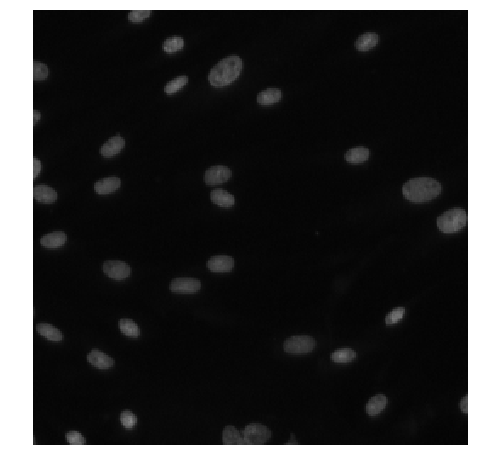

In [176]:
i=i+1 #49 #24 #32 #20
image = dataloader[ i ]
print(i, dataloader.getid() )

nutl.summary(image)
imageshow(image)


In [9]:
# import cv2
# import random

# # preprocessing

# #imaged = cv2.fastNlMeansDenoisingColored(image,None,5,5,7,21)
# #imageshowlist(image, imaged)

# #limit=0.5
# #gamma = 1.0 + limit*random.uniform(-1, 1)  
# gamma = 1.
# table = np.array([((i / 255.0) ** (1.0 / gamma)) * 255
#     for i in np.arange(0, 256)]).astype("uint8")
# imagein = cv2.LUT(image, table) # apply gamma correction using the lookup table


# imageshowlist(image, imagein)

>>
>>
DONE!!


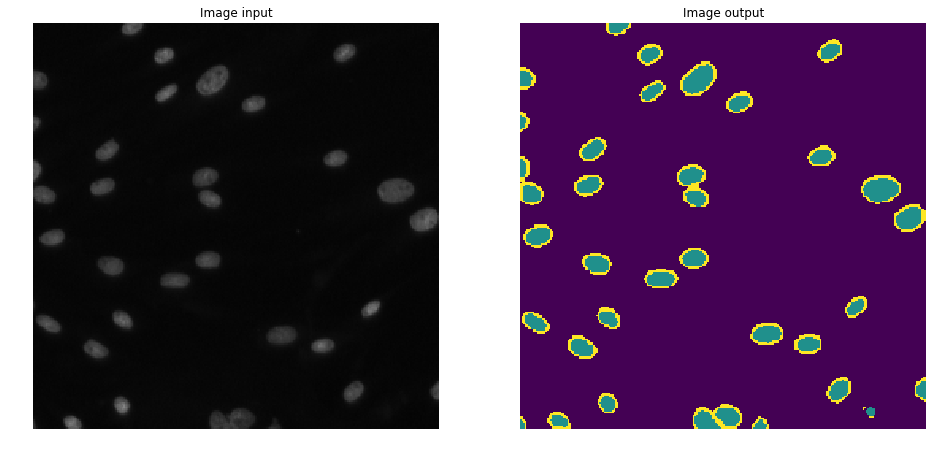

In [177]:
score = segment(image)
predition = np.argmax(score, axis=2).astype('uint8') 

print('DONE!!')
imageshowlist(image, predition)

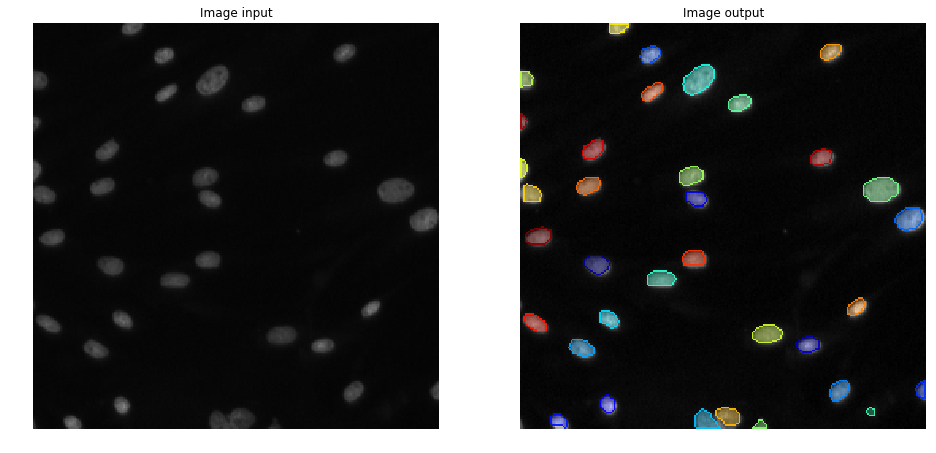

In [178]:
score_prob = nutl.sigmoid(score)
labels_est = posp.mpostprocessthresh(score)
labels_mask_est = np.transpose( labels_est, (1,2,0) )

labels_mask_est = labels_mask_est[:,:, np.random.permutation(labels_mask_est.shape[2]) ]
imagecell_est = view.makeimagecell(image, labels_mask_est, alphaback=0.3, alphaedge=0.9)
imageshowlist(image, imagecell_est )

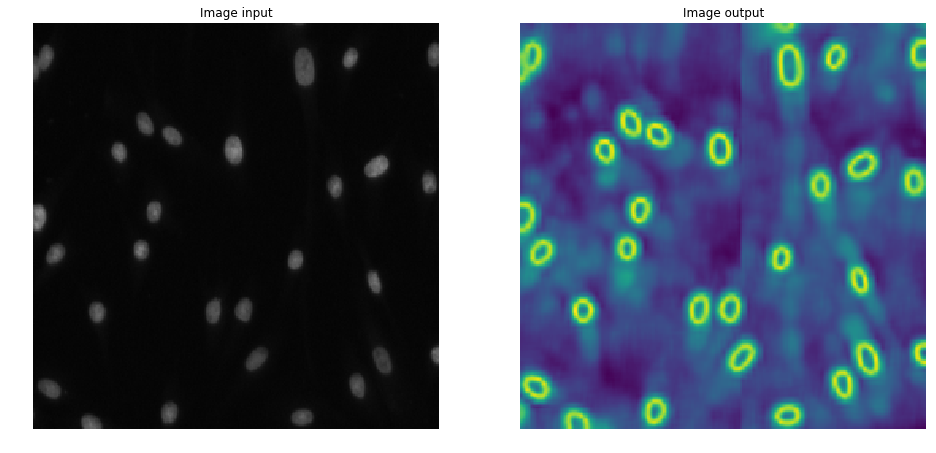

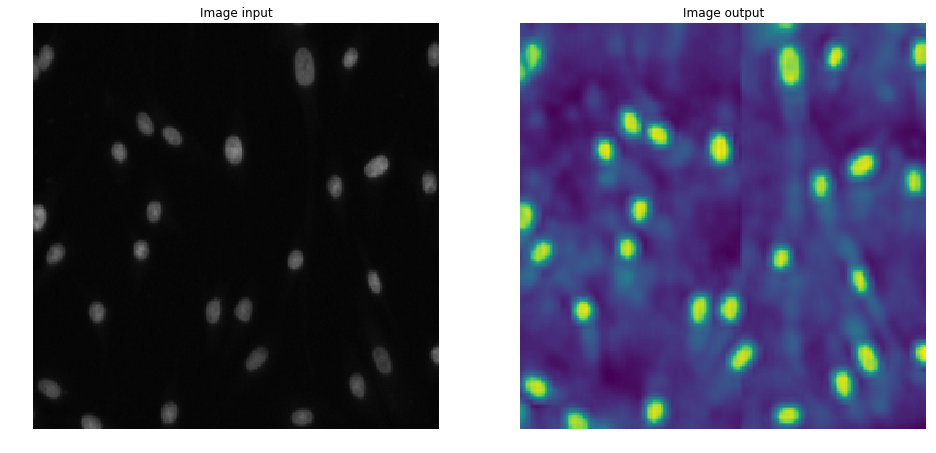

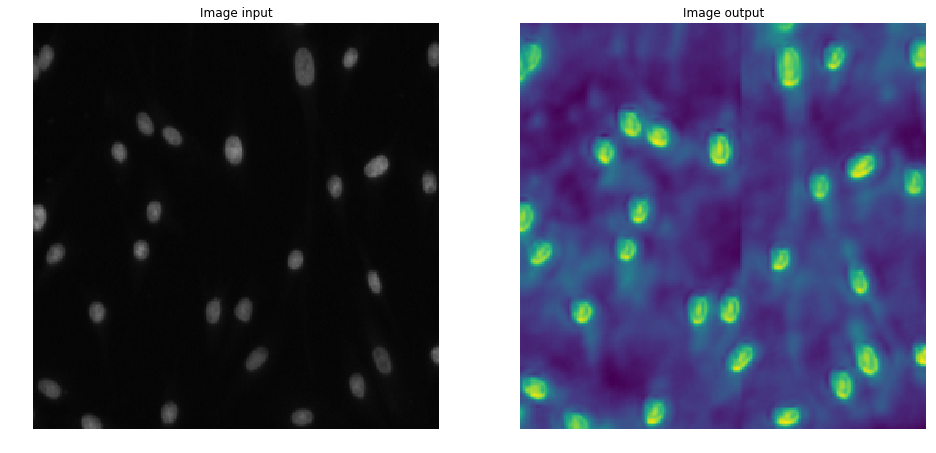

In [13]:
seginfo = nutl.process_data( score[:,:,:2], line_width=1 )

mask_line = seginfo['line_data']>0
image_sh = image.copy()
image_sh[mask_line[:,:,3],:] = [255,0,0];

#imageshowlist(image, image_sh)
imageshowlist(image, score[:,:,2])
imageshowlist(image, score[:,:,1])
imageshowlist(image, score[:,:,0])

(30, 256, 256)
(28, 256, 256)


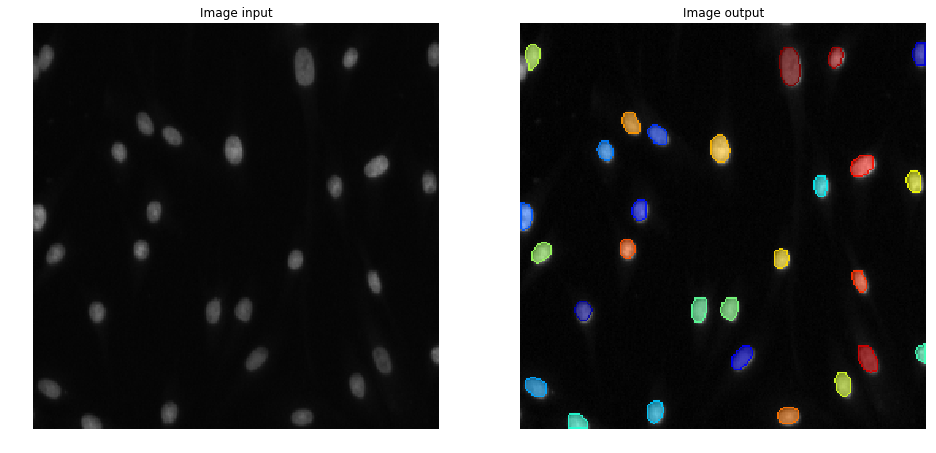

In [14]:
import skimage.morphology as morph
import scipy.ndimage as ndi


def clean_label( masks ):
    
    
    cln_mask = []
    for mask in masks:        
        mask = (mask>128).astype(np.uint8)                
        try:
            _,contours,_ = cv2.findContours(mask, 1, 2) 
            contour = contours[0]
            
            if len(contour) < 5:
                continue
            
            area = cv2.contourArea(contour)
            if area <= 25:  # skip ellipses smaller then 5x5
                continue
            
            epsilon = 0.1*cv2.arcLength(contour,True)
            contour_aprox = cv2.approxPolyDP(contour,epsilon,True)   
            cv2.fillPoly(mask, contour_aprox, 1)  
            
            cln_mask.append(mask)
                        
        except ValueError as e:
            pass
    
    return np.array(cln_mask)



score_prob = nutl.sigmoid(score)
labels_est = posp.mpostprocess(score)
labels_cln = clean_label(labels_est)

print(labels_est.shape)
print(labels_cln.shape)


labels_mask_est = np.transpose( labels_cln, (1,2,0) )

labels_mask_est = labels_mask_est[:,:, np.random.permutation(labels_mask_est.shape[2]) ]
imagecell_est = view.makeimagecell(image, labels_mask_est, alphaback=0.5, alphaedge=0.9)
imageshowlist(image, imagecell_est )


In [ ]:
def create_label( labels ):
    #classe 0 back
    c,m,n = labels.shape
    mlabel = np.zeros_like(labels)
    for i in range(c):
        mlabel[i,:,:] = labels[i,:,:]*(i+1)
        
    mlabel = np.max(mlabel,axis=0)
    return mlabel

labels = create_label(labels_est)
labels = posp.decompose(labels)

labels_mask_est = np.transpose( labels, (1,2,0) )
labels_mask_est = labels_mask_est[:,:, np.random.permutation(labels_mask_est.shape[2]) ]
imagecell_est = view.makeimagecell(image, labels_mask_est, alphaback=0.5, alphaedge=0.9)
imageshowlist(image, imagecell_est )

In [173]:
import scipy.ndimage as ndi

def count(mask):
    labeled, nr_true = ndi.label(mask)
    s = int(np.sum(labeled)>0)
    
    return nr_true,s

score_prob = nutl.sigmoid(score)
labels_est = posp.mpostprocess(score)
labels_est = posp.decompose(labels_est)
total = np.array([ count(x) for x in labels_est ])

nutl.summary(total)

total_t = np.sum(total[:,0])
total_s = np.sum(total[:,1])
print(total_t,total_s, labels_est.shape[0] )



1 1 (82, 2)
82 82 82
